# Notebook 3?

Let's go step-by-step through an inference pipeline to see what `solaris` is doing during that process. For simplicity we'll be using the same image as in Notebook 1.

There are several steps to the inference process:

1. [__Pre-processing input images__](#section1)
2. [__Tiling images to ML-compatible sizes__](#Tiling-images-to-ML-compatible-sizes)
3. Generating predictions with the neural net: see the geo_nets_101 slides
4. [__Going from predictions to geo-registered vector labels__](#Going-from-predictions-to-geo-registered-footprint-labels)

Let's start with input pre-processing.

<a id="section1"></a>
## Pre-processing input images

One of the biggest challenges with analyzing overhead imagery (or really any imagery) with neural networks is ensuring that the input data looks similar enough to what the network was trained on. For example, if the neural net was trained on a 16-bit RGB Pan-sharpened image (31 cm resolution) from DigitalGlobe's WorldView-3 satellite, it's not going to work too well on an 8-bit version of a multispectral image taken from the same satellite. This remains a major barrier for ensuring accurate comparisons of model performance: how can we be sure that the performance of two models applied to the same imagery is truly a reflection of the model, just incompatibility of pre-processing?

Enter `solaris`, which provides a simple way to build pre-processing pipelines into model inputs. Solaris provides two approaches for normalization of inputs:
1. __Recommended:__ normalize inputs during model ingestion using [albumentations](https://albumentations.readthedocs.io), an image transformation library (initially created by [Alexander Buslaev](https://github.com/albu), a Mapbox computer vision engineer, Kaggle Master, and SpaceNet Challenge participant)
2. Normalize inputs during image read-in with [`sol.utils.io.imread`](https://solaris.readthedocs.io/en/latest/api/utils.html#solaris.utils.io.imread)
3. _Discouraged_: Pre-process your images beforehand and do not normalize after ingestion: You _can_ do this, but it makes it much harder for others to use your models, and requires you to write custom normalization scripts for every dataset you want to use that model on!

Let's dig into 1. more closely: how does our sample configuration file specify input data normalization? The following lines from the YAML file define it:

```yaml
inference_augmentation:
  augmentations:
    DropChannel:
      idx: 3
      axis: 2
      p: 1.0
    Normalize:
      mean:
        - 0.006479
        - 0.009328
        - 0.01123
      std:
        - 0.004986
        - 0.004964
        - 0.004950
      max_pixel_value: 65535.0
      p: 1.0
  p: 1.0
```

The model will ingest the source imagery, then perform the following operations:

- `DropChannel`: Drop the channel at index 3 in the axis at index 2 (the band axis). This channel corresponds to the Near-IR band in the input imagery, which the SpaceNet competitor did not use in his model. It is done to every image (`p=1.0`).
- `Normalize`: Each channel is individually normalized (z-scored) using [albumentations' `Normalize`](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Normalize). The mean and standard deviation (`std`) values were calculated for this specific dataset, and would need to be determined on a dataset-by-dataset basis. `max_pixel_value` specifies the max value of the bit depth of the input (`65535` for 16-bit). This is done to every image (`p=1.0`).

And that's all there is to it! There are many different augmentations that can be applied (see the [albumentations documentation](https://albumentations.readthedocs.io) and the [solaris docs](https://solaris.readthedocs.io/en/latest/api/nets.html#module-solaris.nets.transform) for the full lists). For example, during training, it's often important to re-size an image to fit into a neural network's architecture.

## Tiling images to ML-compatible sizes

 When we trained this model, we achieved this by randomly cropping out an appropriate-sized portion of each image, as indicated in the config file:

```yaml
training_augmentation:
  augmentations:
    (...)
    RandomCrop:
      height: 512
      width: 512
      p: 1.0
```
Because a different crop is taken at each epoch, we still get full dataset coverage during training. Other approaches, such as re-sizing the image to different dimensions, are also available.

__However, this doesn't work for inference, where we want to make sure we get predictions across the entire image.__ To address this, `solaris` contains another object for ingesting inference data, the [`InferenceTiler`](https://solaris.readthedocs.io/en/latest/api/nets.html#solaris.nets.datagen.InferenceTiler). This object chips out images into tiles of the desired size, runs pre-processing on them, and can then feed them into the neural net for prediction:

<img src='files/inference_tile_ex.png' style='width:1000px'>

There are also options to tile with overlap and average the results, to avoid edge effects - see the documentation for [`sol.nets.datagen.InferenceTiler`](https://solaris.readthedocs.io/en/latest/api/nets.html#solaris.nets.datagen.InferenceTiler) and [`sol.vector.mask.mask_to_poly_geojson`](https://solaris.readthedocs.io/en/latest/api/vector.html#solaris.vector.mask.mask_to_poly_geojson) for details.

So, now you understand how data is tiled for inference - but what is the ML model actually doing?

## Generating predictions with the neural net

<font color="red"><em>Pause here for slides (geo_nets_101)</em></font>


## Going from predictions to geo-registered footprint labels

As you could see from the slides (and the intro notebook), `solaris` takes the raw pixel-wise predictions and converts them into vector-formatted labels. How does it do this?

Two steps:
1. Binarize
2. Convert to vector-formatted, georegistered labels

`solaris` provides a single function that integrates both of these steps: [`sol.vector.mask.mask_to_poly_geojson()`](https://solaris.readthedocs.io/en/latest/api/vector.html#solaris.vector.mask.mask_to_poly_geojson). Let's go through an example of how to use this:

Text(0.5, 1.0, 'Confidence value histogram')

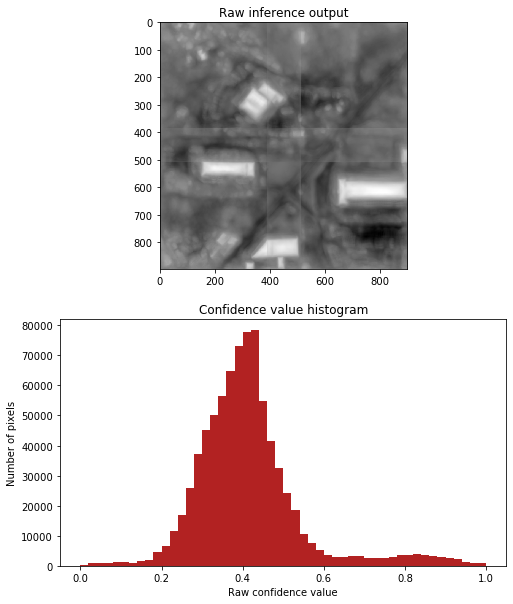

In [19]:
import solaris as sol
import skimage
import os
from matplotlib import pyplot as plt

data_path = 'data'  # NON-WORKSHOP PARTICIPANTS: change this path to point to the directory where you've stored the data.
src_im_path = os.path.join(data_path, 'MVOI_data/MVOI_nadir10_test_sample.tif')
inference_output_path = "inference_out/MVOI_nadir10_test_sample.tif"
inference_arr = skimage.io.imread(inference_output_path)[:, :, 0]
# first, we'll normalize to a 0-1 range for simple interpretation
# 0 = lower p(building), 1 = higher p(building)

inference_arr = inference_arr - inference_arr.min()
inference_arr = inference_arr/inference_arr.max()

f, axarr = plt.subplots(2, 1, figsize=(8,10))

axarr[0].imshow(inference_arr, cmap='gray')
axarr[0].set_title('Raw inference output')
axarr[1].hist(inference_arr.flatten(), bins=50, color='firebrick');
axarr[1].set_ylabel('Number of pixels',)
axarr[1].set_xlabel('Raw confidence value')
axarr[1].set_title('Confidence value histogram')

As we can see, this yields one major peak of relatively low-confidence pixels, and some higher-valued pixels. Presumably the majority of pixels don't correspond to buildings, so we'll want to binarize with a threshold somewhere above 0.6 so that those pixels are set to background. `sol.vector.mask.mask_to_poly_geojson()` allows the user to provide a `bg_threshold` argument that specifies the value to separate foreground and background. Let's first try 0.75.

In [34]:
inferred_vectors = sol.vector.mask.mask_to_poly_geojson(
    inference_arr,
    bg_threshold=0.75,
    reference_im=src_im_path,
    do_transform=True)

`inferred_vectors` is a [GeoPandas](http://geopandas.org/) `GeoDataFrame` containing the geometries in the WGS84 UTM zone for Atlanta.

In [35]:
inferred_vectors

,geometry,value
0,"POLYGON ((745940 3726373, 745943 3726373, 7459...",255.0
1,"POLYGON ((745921 3726364.5, 745921.5 3726364.5...",255.0
2,"POLYGON ((746196 3726252, 746198 3726252, 7461...",255.0
3,"POLYGON ((745835 3726233, 745840.5 3726233, 74...",255.0
4,"POLYGON ((746077.5 3726200, 746079.5 3726200, ...",255.0
5,"POLYGON ((745994.5 3726093, 745996.5 3726093, ...",255.0
6,"POLYGON ((745967.5 3726059, 745971.5 3726059, ...",255.0
7,"POLYGON ((745909.5 3726048.5, 745912 3726048.5...",255.0


Let's visualize those geometries:

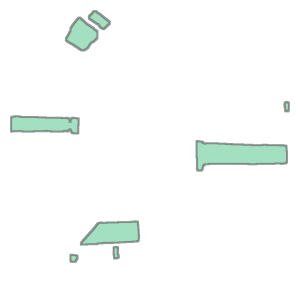

In [36]:
from shapely.ops import cascaded_union  # for viz of vector output
cascaded_union(inferred_vectors.geometry.values)

Let's compare this to the ground truth.

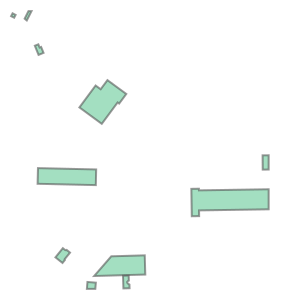

In [37]:
import geopandas as gpd
ground_truth_path = os.path.join(data_path,
                                 'MVOI_data/MVOI_nadir10_test_sample.geojson')
ground_truth_geoms = gpd.read_file(ground_truth_path)
cascaded_union(ground_truth_geoms.geometry.values)


In truth, these look quite similar; however, we can toy with the threshold and see if it improves performance. Try it out in the cell below!

In [ ]:
threshold_value = 0.75  # MODIFY THIS TO OPTIMIZE!

inferred_vectors = sol.vector.mask.mask_to_poly_geojson(
    inference_arr,
    bg_threshold=threshold_value,
    reference_im=src_im_path,
    do_transform=True)

cascaded_union(inferred_vectors.geometry.values)

This output can be saved to whatever format `geopandas` can save to (we usually use GeoJSON).

_Coming up next:_ How would you score performance? What metrics would you use, and why?